In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torchvision
import os
import cv2 as cv
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

### custom dataset class

In [3]:
classes=["COVID","Lung_Opacity","Normal","Viral_Pneumonia"]

class XrayImagesDataset(Dataset):
  def __init__(self,data_dir,classes,transform):
    
    self.data_dir=data_dir
    self.transform=transform
    self.classes=classes
    self.data=[]
    
    for c in self.classes:
      for img in os.listdir(self.data_dir+"/"+c+"/images/"):
        self.data.append({"path":img,"class":c})
  
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self,index):
    
    img_class=self.data[index]["class"]
    img_name=self.data[index]["path"]
    path=self.data_dir+"/"+img_class+"/images/"+img_name
    
    image =  Image.open(path).convert('RGB')
        
    return self.transform(image),classes.index(self.data[index]["class"])

In [4]:
#resnet takes 224,224 so i'll resize all images i don't feel like augmenting them 😶‍🌫️
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
])
data=XrayImagesDataset("dataset/COVID-19_Radiography_Dataset",classes,transform)

### data splitting into train val and test then loading it in the dataloader

In [5]:
#so i tried this the other way by splitting the custom dataset class
#then loading train valid test seperately but SPLITTING TOOK AGES
#so i used this method i found online it splits data indices instead of
#the data itself then uses the pytorch Subset class for each split and loads 
indices = list(range(data.__len__()))

train_indices, valid_and_test_indices = train_test_split(indices, test_size=0.2, random_state=42)

valid_indices, test_indices = train_test_split(valid_and_test_indices, test_size=0.5, random_state=42)

train_subset = Subset(data, train_indices)
valid_subset = Subset(data, valid_indices)
test_subset = Subset(data, test_indices)

batch_size=10

train_dataloader = DataLoader(train_subset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_subset, batch_size=batch_size)

### some visualisation

In [6]:
#get the first batch of images
images, labels = next(iter(train_dataloader))

In [7]:
#why are the channels there whatever i'll transpose
images[0].shape

torch.Size([3, 224, 224])

In [8]:
#first dim is data length/batch size 
images.shape

torch.Size([10, 3, 224, 224])

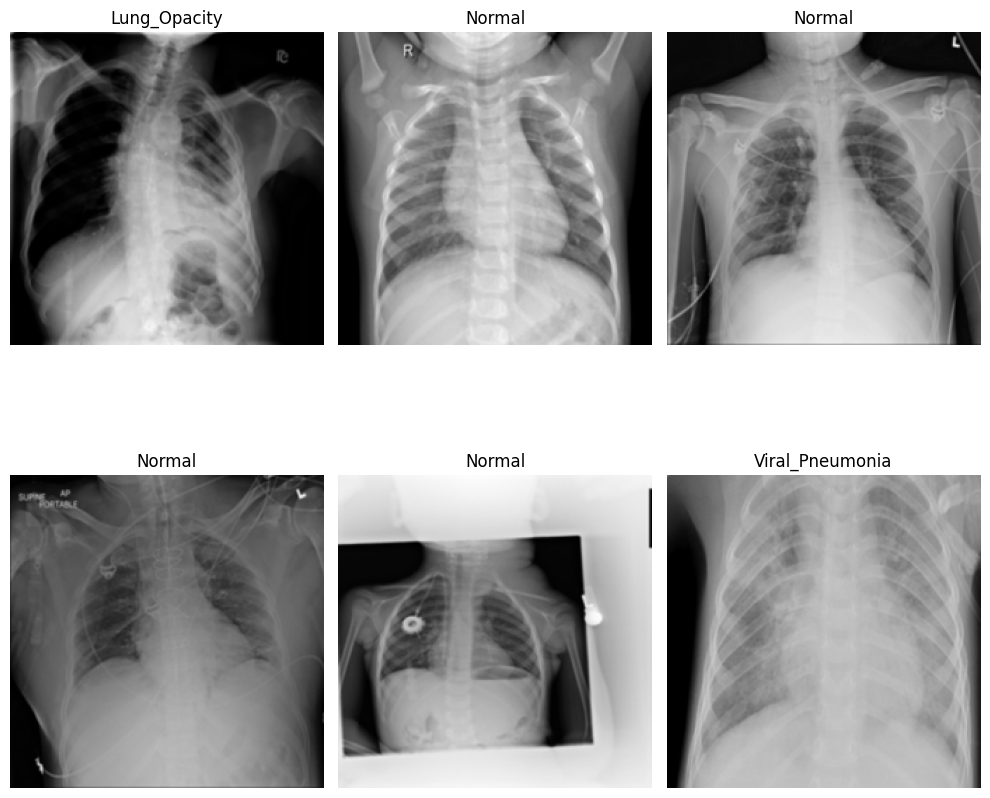

In [9]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    #transpose because pillow wants to act all different and cool
    image = images[i].numpy().transpose((1, 2, 0))
    plt.title(classes[int(labels[i])])
    plt.axis('off')
    plt.imshow(np.asarray(image))
plt.tight_layout()
plt.show()

### fine tuning some models you know the drill

In [10]:
resnet50 = torchvision.models.resnet50(pretrained=True)
mobilenetv3=torchvision.models.mobilenet_v3_large(pretrained=True)

d:\dev stuff\vgg16-test\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\dev stuff\vgg16-test\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\dev stuff\vgg16-test\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weig

In [11]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## choose between fine tuning and transfer learnign

In [12]:
#freeze all layers
for param in resnet50.parameters():
    param.requires_grad = False

### fine tuning

In [13]:
#finetuning 
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=4)

#unfreeze the last (4th) layer and the classifier meaning i'll only train them
for param in resnet50.layer4.parameters():
    param.requires_grad = True

for param in resnet50.fc.parameters():
    param.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()

#add more trainable params by unfreezing other layers if you want
trainable_params=list(resnet50.layer4.parameters())+list(resnet50.fc.parameters())

#btw change learning rate if you want
optimizer = torch.optim.Adam(trainable_params, lr=0.00001)

### transfer learning

In [ ]:
#only train the classifier
for param in resnet50.fc.parameters():
    param.requires_grad = True
    
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.00001)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs, labels = images.to(device), labels.to(device)

In [15]:
#i'll do this on my gpu may god have mercy on your soul if you're doing it on cpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
# images=torch.tensor(images).to(device)
# labels=torch.tensor(labels).to(torch.device(device))

In [16]:
labels.shape[0]

10

In [ ]:
def train(model,epochs):
    print('TRAINING')
    
    #for plotting loss and acc hist
    
    train_loss_hist=[]
    train_acc_hist=[]
    val_loss_hist=[]
    val_acc_hist=[]
  
    
    for e in range(epochs):
        print('-'*30)
        print(e + 1,'/',epochs,"epochs")
        print('-'*30)

        train_loss = 0.
        correct_train = 0
        #set model to training mode
        model.train() 

        # run training loop
        for train_step, (images, labels) in enumerate(train_dataloader):
            #pass images to model, calculate loss, run back propagation, calculate train acc
            optimizer.zero_grad()
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            
            if train_step % 10 == 0:    
                print("step: ", train_step,"/",len(train_dataloader))
        
        # print train loss and accuracy across all steps
        train_loss /= len(train_dataloader)
        train_acc = correct_train / len(train_dataloader.dataset)

        print("train loss:", train_loss,"train acc: ",train_acc,flush=True)
        
        #add loss and acc to hist to visualise later
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        
        # set model to eval and run validation loop, it's almost the same as train loop
        val_acc = 0
        val_loss= 0
        model.eval()
        
        for val_step, (images, labels) in enumerate(valid_dataloader):
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_acc += sum((preds == labels).cpu().numpy())
            
            
        val_loss /= len(valid_dataloader)
        val_acc = val_acc/len(valid_dataloader.dataset)
        
        val_loss_hist.append(val_loss / len(valid_dataloader))
        val_acc_hist.append(val_acc)
        
        print("val_loss: ",val_loss,"val_acc: ",val_acc)
        
    print('ts training is done bro')
    return train_loss_hist,train_acc_hist,val_loss_hist,val_acc_hist

In [18]:
train_loss_hist,train_acc_hist,val_loss_hist,val_acc_hist=train(resnet50,1)

TRAINING
------------------------------
1 / 1 epochs
------------------------------
step:  0 / 1694
step:  10 / 1694
step:  20 / 1694
step:  30 / 1694
step:  40 / 1694
step:  50 / 1694
step:  60 / 1694
step:  70 / 1694
step:  80 / 1694
step:  90 / 1694
step:  100 / 1694
step:  110 / 1694
step:  120 / 1694
step:  130 / 1694
step:  140 / 1694
step:  150 / 1694
step:  160 / 1694
step:  170 / 1694
step:  180 / 1694
step:  190 / 1694
step:  200 / 1694
step:  210 / 1694
step:  220 / 1694
step:  230 / 1694
step:  240 / 1694
step:  250 / 1694
step:  260 / 1694
step:  270 / 1694
step:  280 / 1694
step:  290 / 1694
step:  300 / 1694
step:  310 / 1694
step:  320 / 1694
step:  330 / 1694
step:  340 / 1694
step:  350 / 1694
step:  360 / 1694
step:  370 / 1694
step:  380 / 1694
step:  390 / 1694
step:  400 / 1694
step:  410 / 1694
step:  420 / 1694
step:  430 / 1694
step:  440 / 1694
step:  450 / 1694
step:  460 / 1694
step:  470 / 1694
step:  480 / 1694
step:  490 / 1694
step:  500 / 1694
step:  51

### train val loss acc hists

In [20]:
train_loss_hist

[0.44293053588283454]

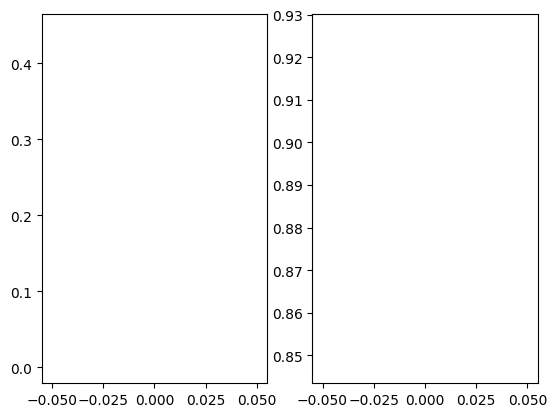

In [19]:
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="val")

plt.show()

### plotting some tests

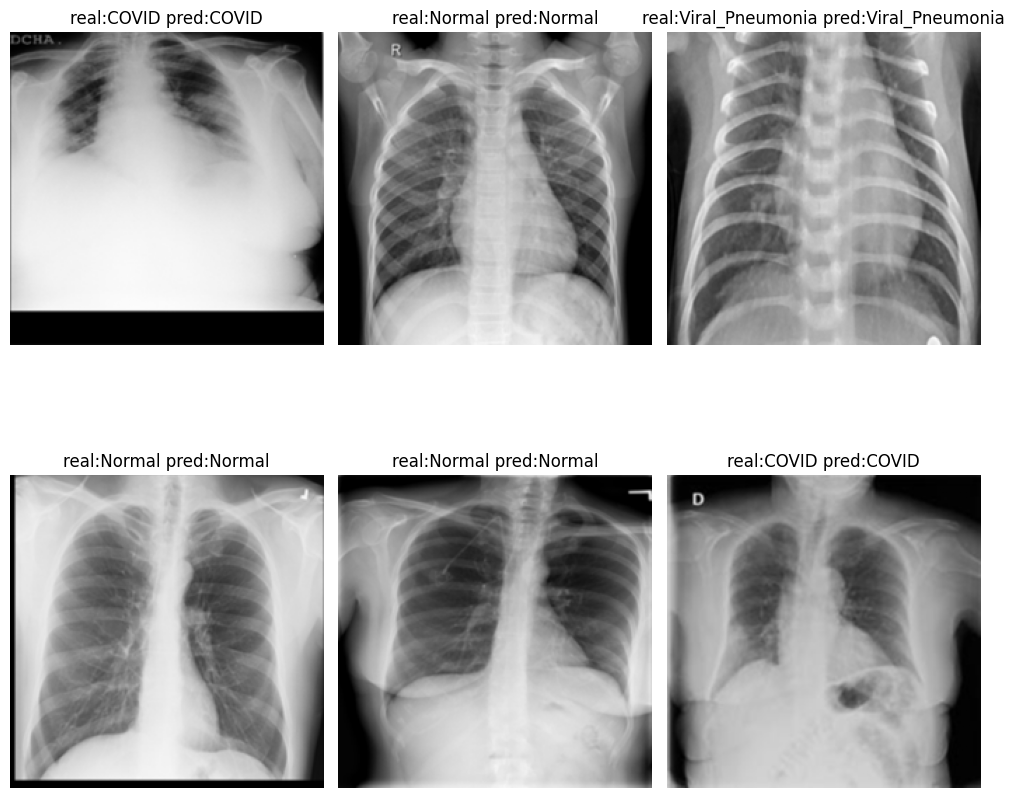

In [21]:
resnet50.eval()
images, labels = next(iter(test_dataloader))
images, labels =images.to(device), labels.to(device)
outputs = resnet50(images)
_, preds = torch.max(outputs, 1)
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1) 
    #transpose because pillow wants to act all special and different from opencv and stuff whatever man
    image = images[i].cpu().numpy().transpose((1, 2, 0))
    plt.title("real:"+str(classes[int(labels[i])])+" pred:"+str(classes[int(preds[i])]))
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()
plt.show()

### saving the model

In [22]:
torch.save(resnet50.state_dict(),"resnet50.pth")

### loading it again for fun

In [23]:
model=resnet50
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=4)
model.load_state_dict(torch.load("resnet50.pth"))

<All keys matched successfully>

### plotting some predictions

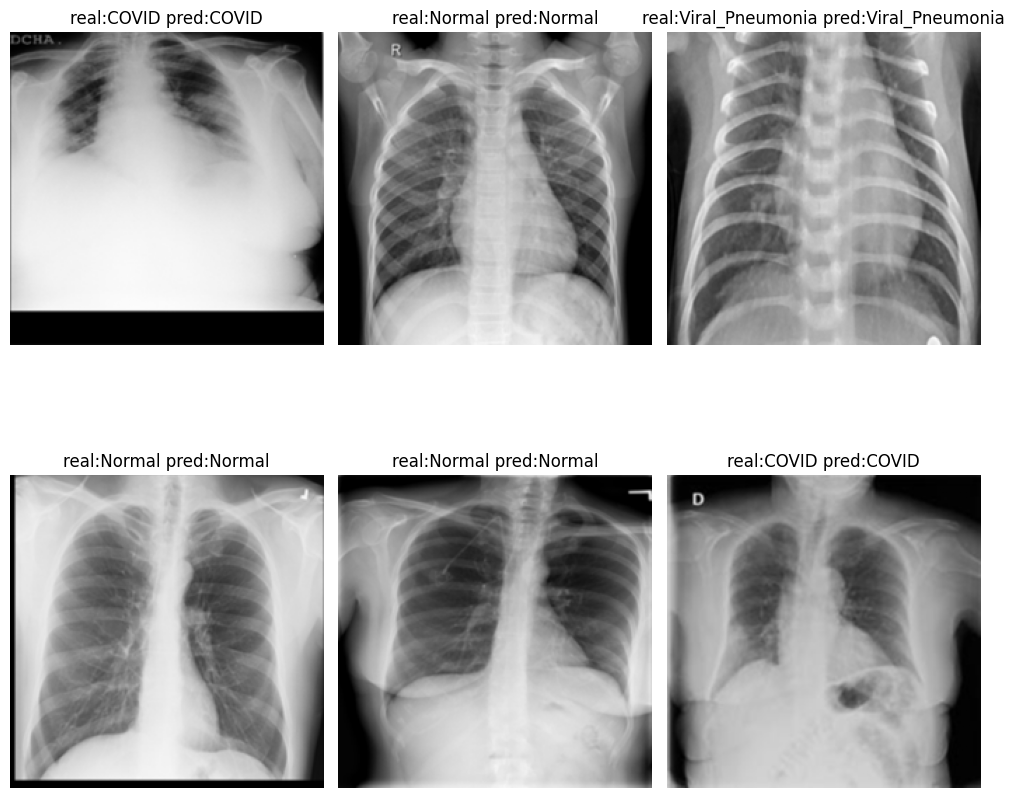

In [24]:
model.eval()
images, labels = next(iter(test_dataloader))
images, labels =images.to(device), labels.to(device)
model.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1) 
    #transpose because pillow wants to act all special and different from opencv and stuff whatever man
    image = images[i].cpu().numpy().transpose((1, 2, 0))
    plt.title("real:"+str(classes[int(labels[i])])+" pred:"+str(classes[int(preds[i])]))
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()
plt.show()

### confusion matrix and evaluation metrics

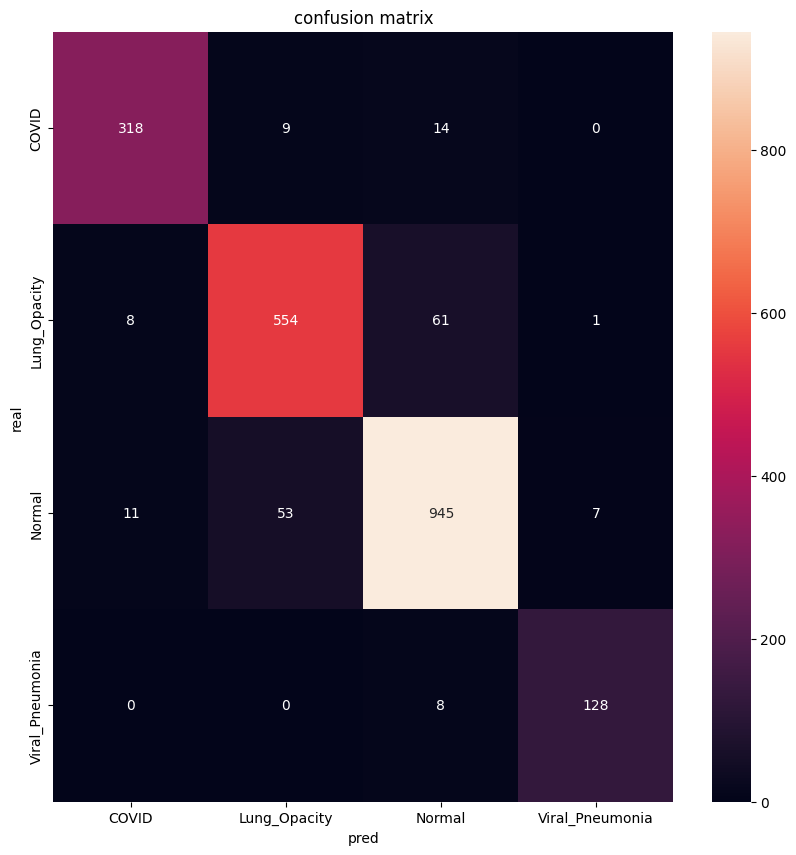

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

y_pred = []
y_test = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        res = model(images)
        _, preds = torch.max(res, 1)

        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred),fmt="d", annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel("pred")
plt.ylabel("real")
plt.title("confusion matrix")
plt.show()

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       341
           1       0.90      0.89      0.89       624
           2       0.92      0.93      0.92      1016
           3       0.94      0.94      0.94       136

    accuracy                           0.92      2117
   macro avg       0.93      0.92      0.92      2117
weighted avg       0.92      0.92      0.92      2117

